## Pre-process
Since our data is small, we augment them by enhance brightness, flipping, shifting each image from downloaded dataset.
The following notes how many images are enhance for each augmented type 

leaked pipe images :
- bright : 149  
- flip : 522 
- translate : 149

working pipe images : 
- bright : 250 
- flip : 300  
- translate : 250  

total images :
- Found 1346 images belonging to leaked
- Found 1434 images belonging to 1 working pipe.


## Modification : to fix overfitting
resource 
1. prevent overfit [link](https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d)

Model choice 
1. use a baseline CNN Lenet-5 model and modify in respect to our current water pipe data

Procedure taken 
1. re-clean and re-download the dataset from google such that each images are more relevant.<br> (irrelevant: a human fixing pipe, relevant: a closer look on a pipe)
2. add dropout, randomly dropping 35 percent of neurons at each layer and reduced number of epochs
<br>Observation : validation loss still fail to decrease
3. on top of (2), then applied L2 regularization with  
Observation : 1. validation loss starts to decrease by 1-3% for every epochs. 2. validation accuracy stays stagnant
4. run the model with more epoch, stop training at 2/5 epoch
<br>Observation : 1. validation loss fails to decrease
5. reduce kernel filter size for 2 different layers from 3->2 and 5->4
<br>Observation : 1. val_loss reduce for 15 epochs, but increase its loss after 15
6. download more images until it reach 5000



Questions : 
- what kind of model successfully predict/classify which kind of image ? This questions raised is to check the necessity of changing the model architecture.
- how to diagnose and fix overfitting


In [1]:
import os 
os.getcwd()

'C:\\Users\\koukiDevice\\pipe detection'

In [2]:
# getting directory where water pipe dataset are located 
directory = r'C:\Users\liewg\OneDrive\Desktop\dataset water pipe'

In [67]:
# checking image count and catagories
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
path = r'C:\Users\koukiDevice\Desktop\augmented pipe images'

# load image
height =300
width = 300

leaked_ds = datagen.flow_from_directory(path , target_size = (height,width),classes=['leaked pipes'])
nonLeaked_ds = datagen.flow_from_directory(path, target_size = (height,width),classes=['pipes'])

Found 1993 images belonging to 1 classes.
Found 1434 images belonging to 1 classes.


In [8]:
# split leaked and non-leaked images to train/test/validation file with ratio 7:1:1
# note that : splitting shuffles the data into folders
import splitfolders
directory = r'C:\Users\koukiDevice\Desktop\augmented pipe images'
splitfolders.ratio(directory, output='images', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 2780 files [00:07, 380.67 files/s]


In [64]:
# getting splited dataset 
from keras.preprocessing.image import ImageDataGenerator

# generate batches
datagen = ImageDataGenerator(rescale=1./255)

# define pixel value for each images 
height = 300
width  = 300
p_size = (height,width)

# directory of splitted dataset 
direct = r'E:/splitted dataset/'

# define train/val/test data 
train_data = datagen.flow_from_directory('images/train', target_size = p_size,batch_size=10)
val_data  = datagen.flow_from_directory('images/val',  target_size = p_size,batch_size=10)
test_data = datagen.flow_from_directory('images/test', target_size = p_size,batch_size=10)

Found 1945 images belonging to 2 classes.
Found 416 images belonging to 2 classes.
Found 419 images belonging to 2 classes.


In [14]:
train_data.class_indices.keys()

dict_keys(['leaked pipes', 'pipes'])

In [15]:
train_data[0][0].shape # Batch size, pixel value, channel

(10, 300, 300, 3)

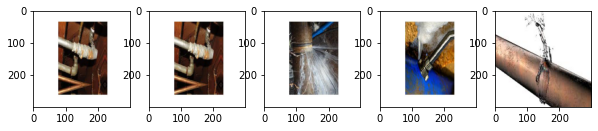

In [16]:
import numpy as np 
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1,5,figsize=(10,10))
for i in range(5):
    ind = np.random.randint(10)
    image = train_data[0][0][ind]
    ax[i].imshow(image,cmap='gray')

In [17]:
from tensorflow.keras import layers, models

# managing inputs 
inputShape = (300, 300, 3)
# define layers 
model = models.Sequential ([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputShape,padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(2, activation='softmax')
        ])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 148, 148, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 331776)            0

## selecting loss, optimizer, metrics
loss : 
- loss calculates the difference between actual and expected prediction
- hinge and squaerd hinge : used for SVM 
- choice of chossing optimizer : https://datascience.stackexchange.com/questions/10523/guidelines-for-selecting-an-optimizer-for-training-neural-networks

In [19]:
model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['acc'])

In [20]:
result = model.fit(train_data, epochs = 30, validation_data = val_data)

Epoch 1/30
 83/195 [===========>..................] - ETA: 1:06 - loss: 0.7824 - acc: 0.5145

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


195/195 [==============================] - 121s 616ms/step - loss: 0.7252 - acc: 0.5188 - val_loss: 0.6652 - val_acc: 0.5361
Epoch 2/30
195/195 [==============================] - 117s 599ms/step - loss: 0.6854 - acc: 0.5630 - val_loss: 0.6832 - val_acc: 0.5264
Epoch 3/30
195/195 [==============================] - 116s 597ms/step - loss: 0.6571 - acc: 0.5594 - val_loss: 0.6701 - val_acc: 0.5529
Epoch 4/30
195/195 [==============================] - 116s 597ms/step - loss: 0.6386 - acc: 0.5902 - val_loss: 0.6950 - val_acc: 0.5577
Epoch 5/30
195/195 [==============================] - 117s 598ms/step - loss: 0.5720 - acc: 0.6761 - val_loss: 0.8035 - val_acc: 0.5577
Epoch 6/30
195/195 [==============================] - 116s 597ms/step - loss: 0.4528 - acc: 0.7712 - val_loss: 0.8632 - val_acc: 0.5769
Epoch 7/30
195/195 [==============================] - 117s 598ms/step - loss: 0.3332 - acc: 0.8396 - val_loss: 1.0799 - val_acc: 0.5865
Epoch 8/30
195/195 [==============================] - 116s 

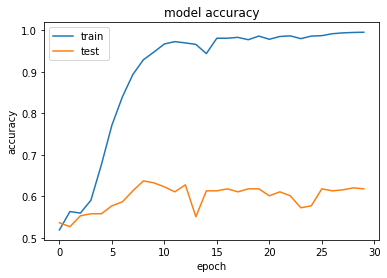

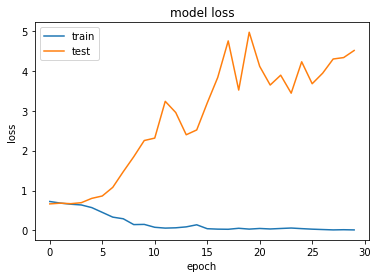

In [21]:
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc']) 
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

notes 
- train : train model, validate: hyperparameter tuning since loss doesn't decrease, test : final testing on unseen image
- we have option to implement early stopping if model doesn't work well 
- perform detail analysis on overfitting to  

In [44]:
from keras import regularizers

In [57]:
# managing inputs 
inputShape = (300, 300, 3)
model2 = models.Sequential ([
    
        layers.Conv2D(8, kernel_size=(2, 2), activation='relu',padding='same',input_shape=inputShape),
        layers.Dropout(0.35),
        layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    
        layers.Conv2D(16, kernel_size=(4, 4), activation='relu'),
        layers.Dropout(0.35),
        layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    
        layers.Flatten(),
    
        layers.Dense(120, kernel_regularizer=regularizers.l2(0.01),activation='relu'),
        layers.Dense(84,  kernel_regularizer=regularizers.l2(0.01),activation='relu'),
        layers.Dense(2, activation='softmax')
    
        ])

In [59]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 300, 300, 8)       104       
                                                                 
 dropout_13 (Dropout)        (None, 300, 300, 8)       0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 150, 150, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 147, 147, 16)      2064      
                                                                 
 dropout_14 (Dropout)        (None, 147, 147, 16)      0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                 

In [60]:
model2.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['acc'])

In [61]:
result2 = model2.fit(train_data, epochs = 50, validation_data = val_data,batch_size=10) # batch_size=batch_size

Epoch 1/50
195/195 [==============================] - 75s 382ms/step - loss: 1.4940 - acc: 0.5584 - val_loss: 0.9623 - val_acc: 0.5721
Epoch 2/50
195/195 [==============================] - 73s 373ms/step - loss: 0.9224 - acc: 0.5594 - val_loss: 0.9187 - val_acc: 0.5168
Epoch 3/50
195/195 [==============================] - 70s 358ms/step - loss: 0.8610 - acc: 0.5625 - val_loss: 0.8455 - val_acc: 0.5337
Epoch 4/50
195/195 [==============================] - 68s 349ms/step - loss: 0.8253 - acc: 0.5517 - val_loss: 0.8189 - val_acc: 0.5697
Epoch 5/50
195/195 [==============================] - 68s 348ms/step - loss: 0.8191 - acc: 0.5943 - val_loss: 0.8192 - val_acc: 0.5505
Epoch 6/50
195/195 [==============================] - 71s 366ms/step - loss: 0.8025 - acc: 0.5738 - val_loss: 0.7661 - val_acc: 0.5577
Epoch 7/50
195/195 [==============================] - 74s 380ms/step - loss: 0.7562 - acc: 0.5681 - val_loss: 0.7360 - val_acc: 0.6250
Epoch 8/50
195/195 [==============================] - 7

KeyboardInterrupt: 